## Vega Hitti 
## 260 381 396 
## PHYS 512 PS7

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import ctypes
import os

## Problem 1

First, I will plot $(ax + by)$ vs. $z$ from the C Standard Library.

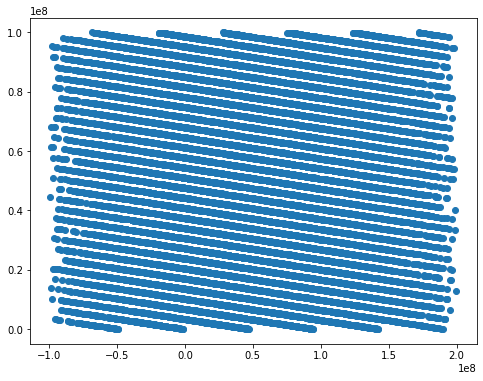

In [8]:
dir = os.chdir(r"C:\Users\Owner\Documents\Classes\F2021\PHYS 512\emacs")

rand_p = np.loadtxt("rand_points.txt")

x = rand_p[:,0]
y = rand_p[:,1]
z = rand_p[:,2]

#Plotting -2x + y vs. z
plt.figure(figsize = (8, 6))
plt.scatter(2*x - y, z)
plt.show()

This plot is clearly not random. There is obviously a correlation between $(2x - y)$ and $z$. 

Now, let's plot $(2x - y)$ vs. $z$ for points given by numpy's random number generator.

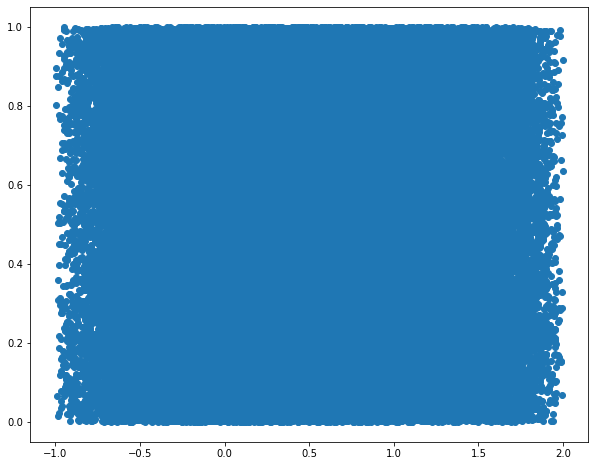

In [16]:
n = len(x)

np_rand_p = np.random.rand(3, int(3*n))

np_x = np_rand_p[0]
np_y = np_rand_p[1]
np_z = np_rand_p[2]

plt.figure(figsize = (10, 8))
plt.plot(2*np_x - np_y, np_z, "o")
plt.show()

There is no apparent trend here. The points seems truly random.

In [19]:
#The following code is directly from test_broken_libc.py

mylib=ctypes.cdll.LoadLibrary("libc.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

@nb.njit

def get_rands_nb(vals):
    
    n=len(vals)
    
    for i in range(n):
        
        vals[i]=rand()
        
    return vals


def get_rands(n):
    
    vec=np.empty(n,dtype='int32')
    
    get_rands_nb(vec)
    
    return vec

n=300000000

vec=get_rands(n*3)

#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])

vmax=np.max(vv,axis=1)

maxval=1e8

vv2=vv[vmax<maxval,:]

x_loc = vv2[:,0]
y_loc = vv2[:,1]
z_loc = vv2[:,2]

plt.figure(figsize = (8, 6))
plt.plot(2*x_loc - y_loc, z_loc)
plt.show()

FileNotFoundError: Could not find module 'libc.dylib' (or one of its dependencies). Try using the full path with constructor syntax.

#### I can't find the proper name for Windows and it's not working.

## Problem 2

We require that the bounding distribution bounds the exponential from above. Let's test all three to see which distributions satisfy this criteria.

<ipython-input-24-41e1c4523d1e>:8: RuntimeWarning: divide by zero encountered in reciprocal
  return x**(-1)


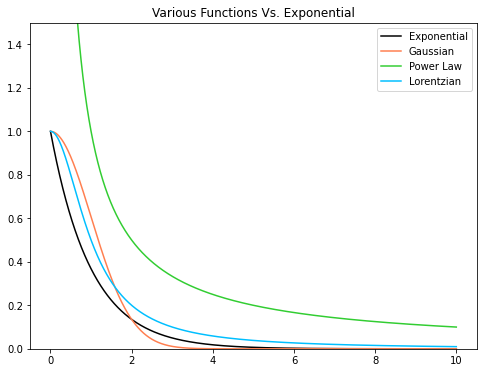

In [24]:
def exp(x):
    return np.exp(-x)

def gauss(x, mu = 0, sig = 1):
    return np.exp(-(mu-x)**2 /(2*sig**2))

def power(x):
    return x**(-1)

def lorentz(x):
    return 1/(1+x**2)

xs = np.linspace(0, 10, 5000)

plt.figure(figsize = (8,6))
plt.plot(xs, exp(xs), c="k", label = "Exponential")
plt.plot(xs, gauss(xs), c="coral", label = "Gaussian")
plt.plot(xs, power(xs), c = "limegreen", label = "Power Law")
plt.plot(xs, lorentz(xs), c = "deepskyblue", label = "Lorentzian")
plt.ylim(ymin = 0, ymax = 1.5)
plt.title("Various Functions Vs. Exponential")
plt.legend()
plt.show()

Clearly, the Gaussian does not bound the exponential from above on this domain. However, the Lorentzian and the Power Law do. We could use either to generate exponential deviates, but we saw in class that the Lorentzian can easily be inverted. So, I will use the Lorentzian. 

The inverse of the CDF of the Lorentzian PDF is given by $\tan(\pi(x-\frac{1}{2}))$

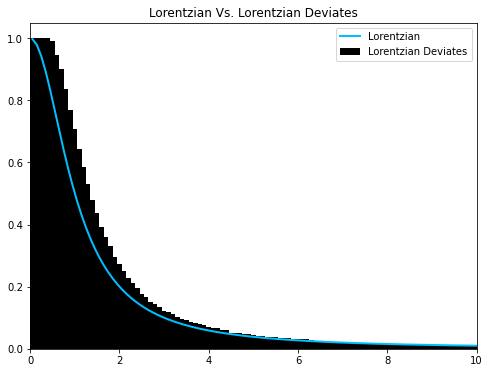

In [36]:
def inv_cdf_lorentz(n):
    
    x = np.random.rand(n)
    
    return np.tan(np.pi*(x-1/2))


#This code is similar to some code that was seen in class
def exp_lorentz(xx):
   
    #ratio of the PDFs
    accept_prob = exp(xx)/lorentz(xx) 
    
    #We require that the ratio < 1 since the Lorentzian bounds from above
    assert(np.max(accept_prob)<=1) 
    
    accept = np.random.rand(len(accept_prob)) < accept_prob
    
    return xx[accept]

n = 1000000
yy = inv_cdf_lorentz(n)
new_yy = yy[np.abs(yy) < 20]
new_new_yy = new_yy[new_yy > 0]

vals, bins = np.histogram(new_new_yy, 200)
mid_bins = 0.5*(bins[1:] + bins[:-1])

plt.figure(figsize = (8, 6))
plt.bar(mid_bins, vals/vals.max(), color = "black", label = "Lorentzian Deviates")
plt.plot(mid_bins, lorentz(mid_bins), c = "deepskyblue", linewidth = "2", label = "Lorentzian")
plt.xlim(xmin = 0, xmax = 10)
plt.legend()
plt.title("Lorentzian Vs. Lorentzian Deviates")
plt.show()

In [39]:
print("The fraction of uniform deviates accepted is {}".format(len(exp_lorentz(new_new_yy))/len(new_new_yy)))

The fraction of uniform deviates accepted is 0.6576215332265152


So roughly 65.76% of the uniform deviates gave rise to an exponential deviate. This seems somewhat efficient.

## Problem 3

We know that $\Large{0 \lt u \lt e^{\Large{\frac{-v}{2u}}}}$ $\Large{\xrightarrow{}}$  $\Large{0 \lt v \lt -u\cdot ln(u^2)}$.

So clearly, $\Large{{v_{max} = \frac{2}{e}}}$.

Thus, $\Large{v \in [0, \frac{2}{e}]}$.

<ipython-input-41-469e68cba45b>:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(mid_bins2, yp, c = "deepskyblue", Label = "Exponential")


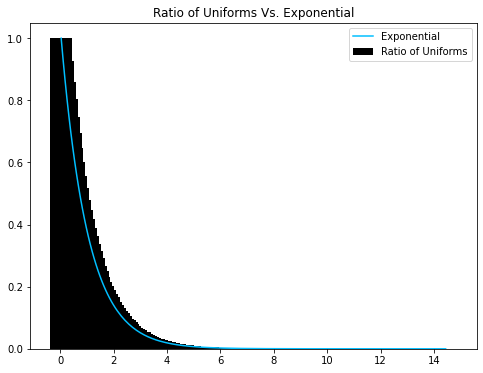

In [41]:
n = 1000000
lim = 2/np.e

u, v = np.random.rand(2, n)
v *= lim
R = v/u

accept = R[u < np.sqrt(np.exp(-R))]

vals2, bins2 = np.histogram(accept, bins = 200)
mid_bins2 = 0.5*(bins2[1:] + bins2[:-1])

yp = exp(mid_bins2)
yp = yp/yp.max()
vals2 = vals2/vals2.max()

plt.figure(figsize = (8,6))
plt.bar(mid_bins2, vals2, color = "black", label = "Ratio of Uniforms")
plt.plot(mid_bins2, yp, c = "deepskyblue", Label = "Exponential")
plt.title("Ratio of Uniforms Vs. Exponential")
plt.legend()
plt.show()

In [42]:
print("The acceptance rate is {}".format(len(accept)/n))

The acceptance rate is 0.68006


So, the acceptance rate is roughly 68.01%. This is slightly better (or more efficient) than the method used in Problem #2.